Before starting, it is necessary changing the environment, and enable a GPU.

Go to the top-right, then downarrow > Resources > Modify execution > GPU.

In [1]:
# Install requirements
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux
!pip install -q transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Stable Diffusion

In [2]:
# Load the libraries used
from diffusers import StableDiffusionControlNetPipeline
from transformers import pipeline
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
from diffusers import ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
import torch

Error caught was: No module named 'triton'


In [3]:
# Helper function to display images as a grid
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

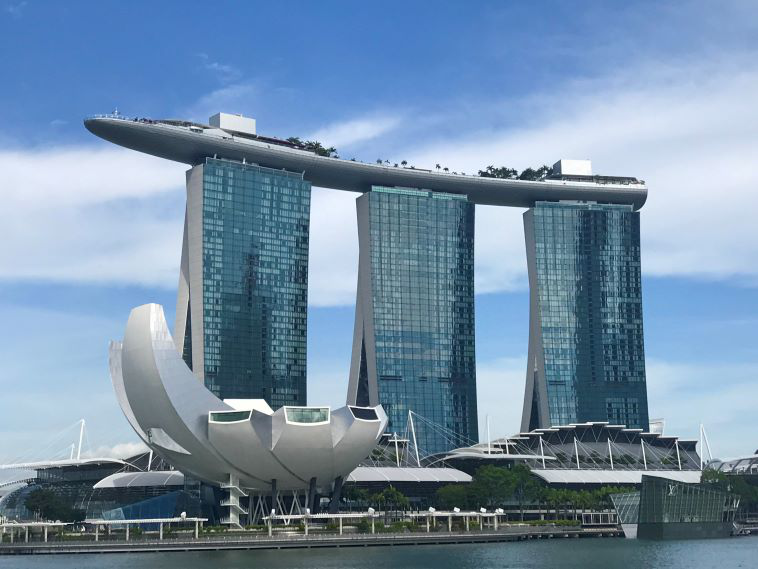

In [4]:
# Load the image (from my computer) then display it
image = load_image(
    # "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
    "MarinaBaySands.jpg"
  )
image

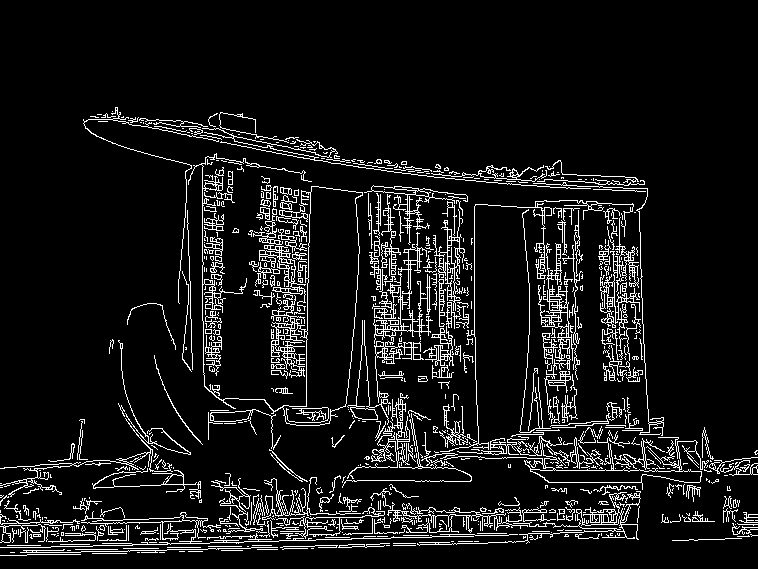

In [5]:
# Put the image in an array
image_arr = np.array(image)

# Set thresholds (different levels of detection)
low_threshold = 100
high_threshold = 250

# Use opencv to make a canny image
image_cv = cv2.Canny(image_arr, low_threshold, high_threshold)
image_cv = image_cv[:, :, None]
image_cv = np.concatenate([image_cv, image_cv, image_cv], axis=-1)
canny_image = Image.fromarray(image_cv)
canny_image

In [6]:
# Load the (pretrained) models
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", 
                                             torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=controlnet, 
    torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [7]:
# Change the scheduler to a faster one to reduce inference time
# More on schedulers: https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Enable smart CPU offloading
pipe.enable_model_cpu_offload()

# Enable xformers attention layer acceleration
# If this gives an error, GPU has not been enabled!
# In case of error, this line can be skipped
pipe.enable_xformers_memory_efficient_attention()

In [8]:
# Define the input prompts (2 in this case), and set seed for reproducability
prompt = ", Marina Bay Sands, High quality, Realistic"
prompt = [t + prompt for t in ["Rain", "Sunset"]]
generator = [torch.Generator(device="cpu").
             manual_seed(23) for i in range(len(prompt))]

  0%|          | 0/20 [00:00<?, ?it/s]

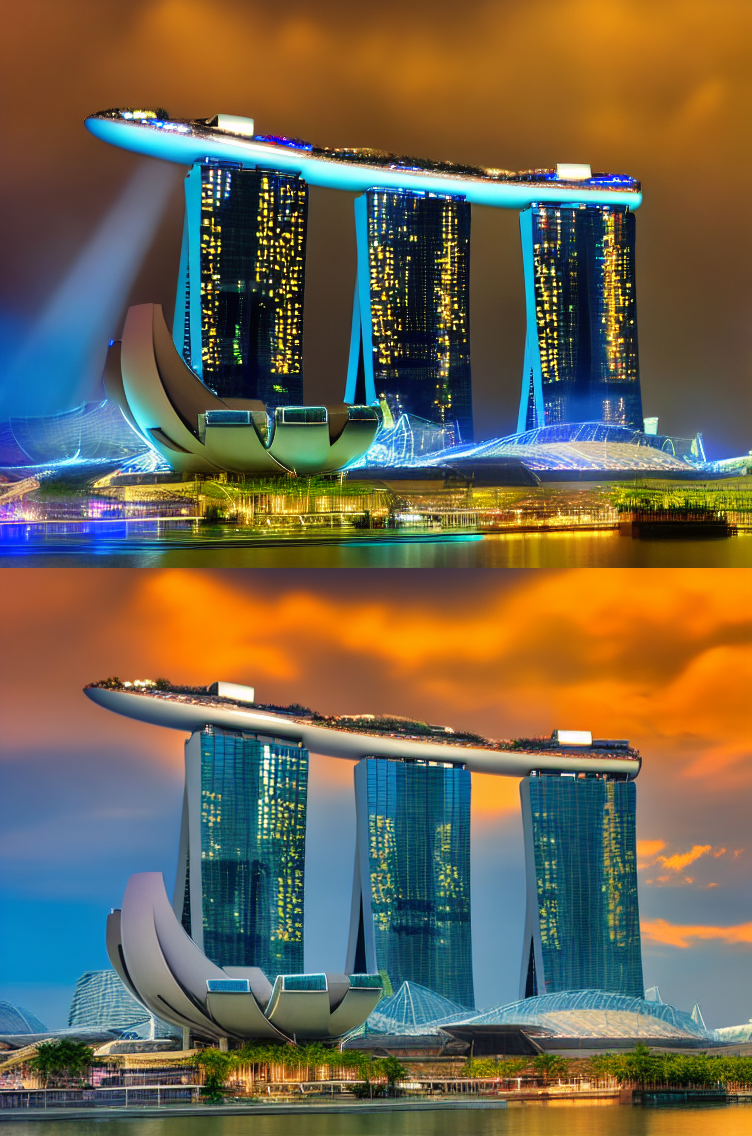

In [9]:
# Run the pipeline and display the images
output = pipe(
    prompt,
    canny_image,
    negative_prompt=[
        "Monochrome, LowRes, Worst quality, Low quality"
        ] * len(prompt),
    num_inference_steps=20,
    generator=generator,
)

# Show the 2 outputs
image_grid(output.images, 2, 1)

# OpenPose

In [2]:
# Reload the libraries used (in case of crash or restart)
from diffusers.utils import load_image
from PIL import Image
from diffusers import ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
import torch

Error caught was: No module named 'triton'


In [3]:
# Helper function to display images as a grid
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

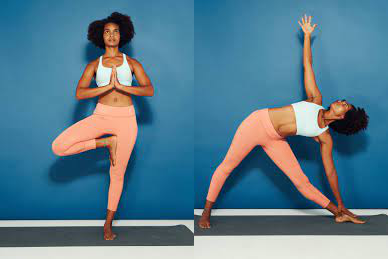

In [4]:
# Retrieve the (4) images from url
#urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
# Retrieve the (2) images from url
urls = "yoga1.jpeg", "yoga2.jpeg"
imgs = [
    load_image("https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/" 
               + url) 
    for url in urls
]

# Display the 2 images
image_grid(imgs, 1, 2)

cuda


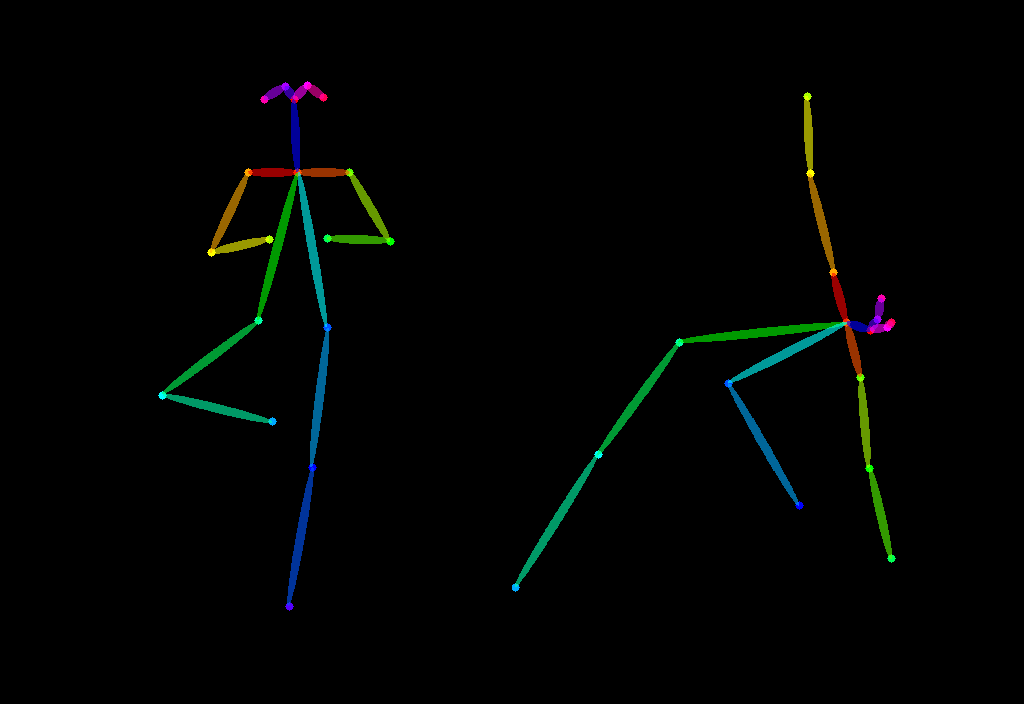

In [5]:
# Extract the yoga poses
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]

# Display the 2 outputs
image_grid(poses, 1, 2)

In [6]:
# Create Open Pose ControlNet to generate new images
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", 
    torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

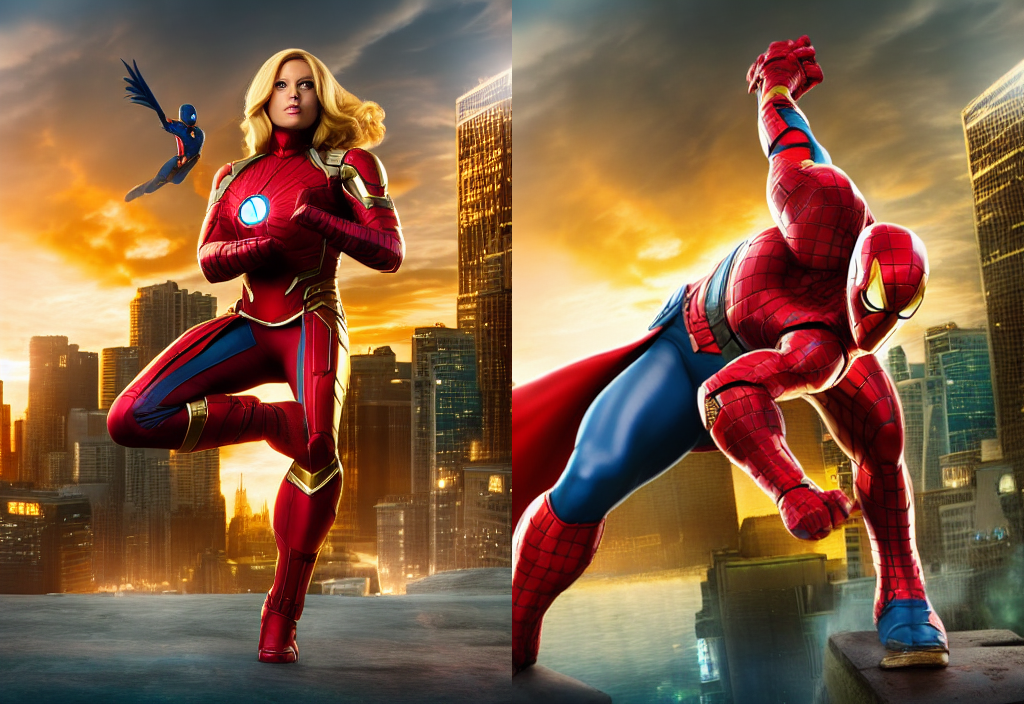

In [8]:
# Define the number of outputs
n_out = len(urls)

# Time for generation!
generator = [
    torch.Generator(device="cpu").manual_seed(23) for i in range(n_out)]
prompt = "Marvel character, High quality, Quite detailed"
output = pipe(
    [prompt] * n_out,
    poses,
    negative_prompt=[
        "Monochrome, LowRes, Bad anatomy, Worst quality, Low quality"
        ] * n_out,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 1, 2)

# Hough Edge Detection (HED) ControlNet

In [2]:
# Reload the libraries used (in case of crash or restart)
from diffusers.utils import load_image
from diffusers import ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
import torch

Error caught was: No module named 'triton'


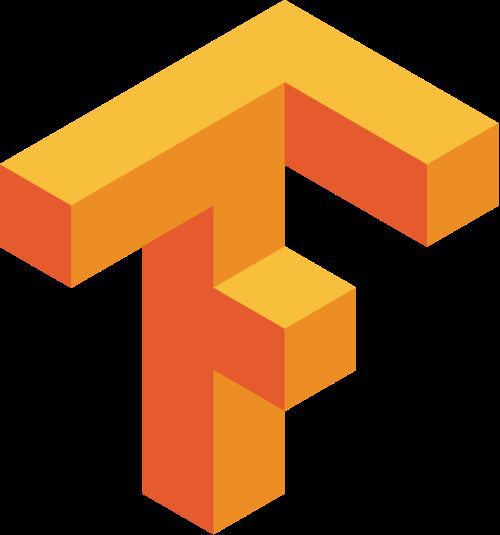

In [3]:
# Load the image (from my computer) then display it
image = load_image(
    "TensorFlowLogo.jpg"
)
image

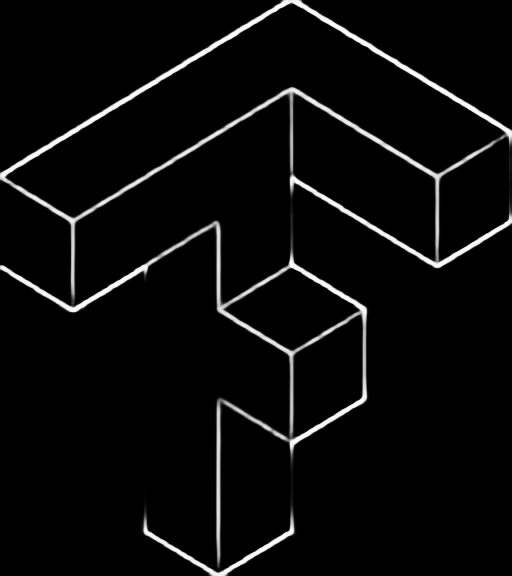

In [4]:
# Detect its "shape"
from controlnet_aux import HEDdetector

model = HEDdetector.from_pretrained("lllyasviel/ControlNet")

img = model(image)
img

In [5]:
# Create HED ControlNet
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-hed", torch_dtype=torch.float16)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, 
    safety_checker=None, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

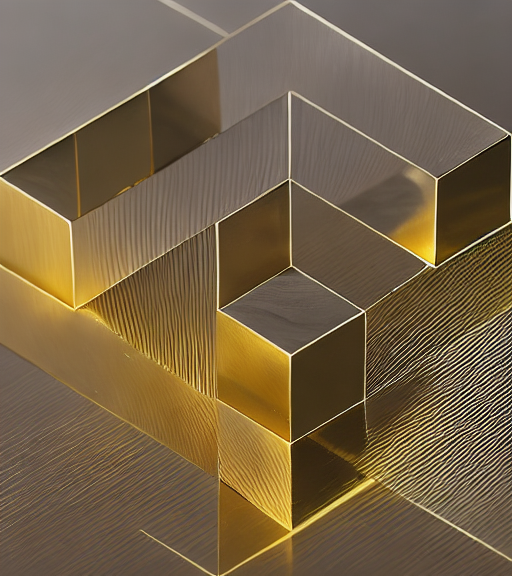

In [6]:
# Try to add "golden" effect to the shape
generator = torch.Generator(device="cpu").manual_seed(23)
prompt = "Golden"
image = pipe(prompt, img, 
             negative_prompt="LowRes, Worst quality, Low quality", 
             generator=generator, num_inference_steps=20).images[0]
image

  0%|          | 0/20 [00:00<?, ?it/s]

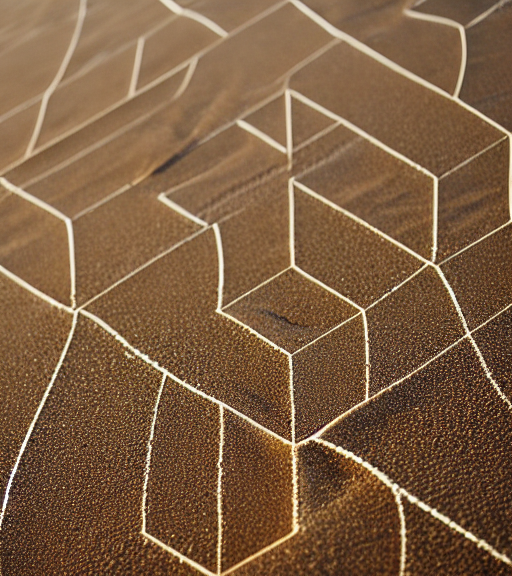

In [7]:
# Maybe try another effect to the shape
generator = torch.Generator(device="cpu").manual_seed(23)
prompt = "Pattern visible in sand on a sandy beach with sea around"
image = pipe(prompt, img, 
             negative_prompt="LowRes, Bad anatomy, Worst quality, Low quality", 
             generator=generator, num_inference_steps=20).images[0]
image

# Normal ControlNet

In [2]:
# Reload the libraries used (in case of crash or restart)
from diffusers.utils import load_image
from transformers import pipeline
import numpy as np
import cv2
from PIL import Image
from diffusers import ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
import torch

Error caught was: No module named 'triton'


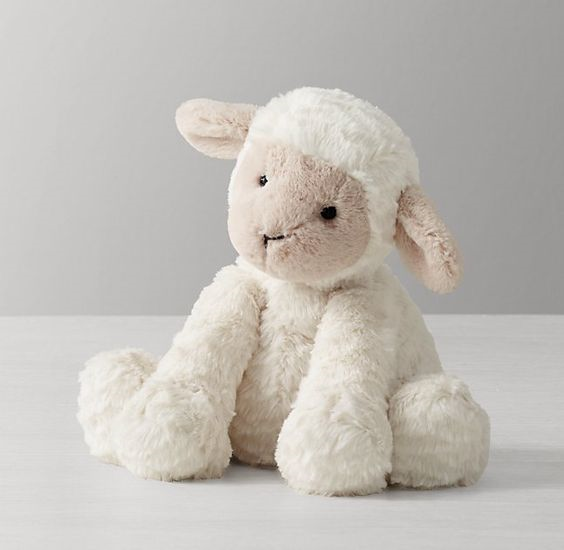

In [3]:
# Loading the base image
image = load_image(
    "https://huggingface.co/lllyasviel/sd-controlnet-normal/resolve/main/images/toy.png").convert("RGB")
image

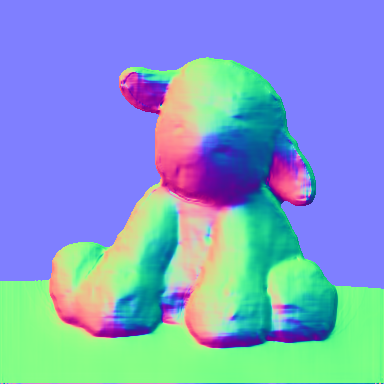

In [4]:
# Let's try another estimator
depth_estimator = pipeline("depth-estimation", model="Intel/dpt-hybrid-midas")

image = depth_estimator(image)['predicted_depth'][0]

image = image.numpy()

image_depth = image.copy()
image_depth -= np.min(image_depth)
image_depth /= np.max(image_depth)

bg_threhold = 0.4

x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
x[image_depth < bg_threhold] = 0

y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
y[image_depth < bg_threhold] = 0

z = np.ones_like(x) * np.pi * 2.0

image = np.stack([x, y, z], axis=2)
image /= np.sum(image ** 2.0, axis=2, keepdims=True) ** 0.5
image = (image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
image = Image.fromarray(image)
image

In [5]:
# Create Normal ControlNet
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-normal", torch_dtype=torch.float16)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, 
    safety_checker=None, torch_dtype=torch.float16
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
# Try to change the filling with a "cute toy"
generator = torch.Generator(device="cpu").manual_seed(23)
prompt = "Cute toy"
br_img = pipe(prompt, image, 
              negative_prompt="LowRes, Bad anatomy, Worst quality, Low quality", 
              generator=generator, num_inference_steps=20).images[0]
br_img

  0%|          | 0/20 [00:00<?, ?it/s]

# Depth ControlNet

In [ ]:
from diffusers.utils import load_image
from transformers import pipeline
import numpy as np
from PIL import Image
from diffusers import ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
import torch

Error caught was: No module named 'triton'


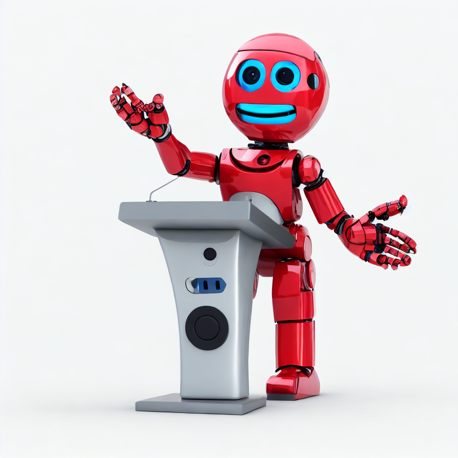

In [ ]:
# Loading the base image
image = load_image(
    "https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png")
image

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


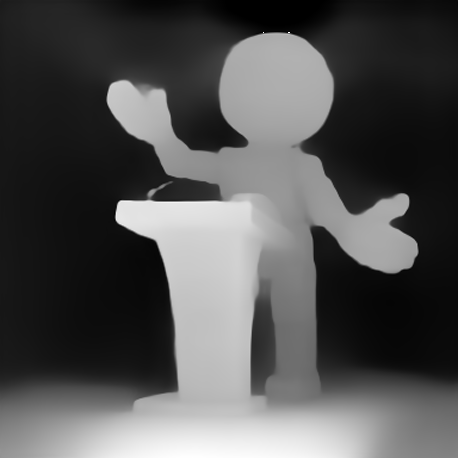

In [ ]:
# Let's try another estimator
depth_estimator = pipeline('depth-estimation')

image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=-1)
image = Image.fromarray(image)

image

In [ ]:
# Create Depth ControlNet
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-depth", torch_dtype=torch.float16)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, 
    safety_checker=None, torch_dtype=torch.float16
    )
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

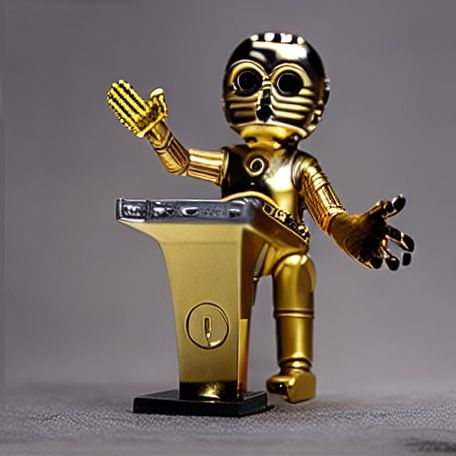

In [ ]:
# Try to add C3PO inside the shape
generator = torch.Generator(device="cpu").manual_seed(23)
prompt = "C3PO"
filled = pipe(prompt, image, 
              negative_prompt="LowRes, Bad anatomy, Worst quality, Low quality", 
              generator=generator, num_inference_steps=20).images[0]
filled